## Decisions logic

Game choice logic:
- Somewhat nieche games with an assumed older audience, so reviews will be more constructive and 
  objective as oposed to having jokes or other off topic content;
- A decent number of reviews and a good balance between positive and negative with little varience overtime.

|      GAME       |  APPID  | POSITIVE REVIEWS | NEGATIVE REVIEWS | PERCENT | TOTAL |
|      :---       |   ---:  |      :---:       |       :---:      |  :---:  | :---: |
| F1 Manager 2024 | 2591280 |       1652       |        830       |   65%   | 2482  |
| Trials Fusion   |  245490 |       1550       |        734       |   66%   | 2284  |

As of 2024/10/12, no filters

---

How does Steam rating work?

<img src="./image/steam-rating.png" width="540px" height="540px" alt="A table with how steam reviews ratings labeling problably translate to recommended percentage">

---

Why leave the filter_offtopic_activity on:  
From [Steam docs](https://partner.steamgames.com/doc/store/reviews#ReviewBombing) on "Review Bombing":

> In all examples, the surge of volume and sentiment will calm down after a few days.
> The reviews during that period will be bucketed by Steam and identified as such by your customers.
> In the case of **off-topic bombs, those reviews will not contribute to your overall score**.
>
> The majority of reviews associated with bombs aren't typically marked as helpful.
> Once the campaign is over, it's less likely that they will be surfaced in your review feed.
> *We also haven't seen a correlation between review bombs and purchasing behavior.*


## Imports and downloads


In [7]:
import datetime
import glob
import io
import logging
import re
import urllib.parse
from string import punctuation
from typing import Any

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from cloudpickle import dump as cloudpickle_dump
from cloudpickle import load as cloudpickle_load
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.util import is_cjk
from rich import print as rprint
from rich.logging import RichHandler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    accuracy_score,
    auc,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud


# from joblib import

In [8]:
_ = nltk.download("punkt_tab")
_ = nltk.download("wordnet")
display(_,clear=True)

True

## Logger and misc

In [9]:
LOG_LEVEL = logging.INFO
logger: logging.Logger = logging.getLogger(__name__)
logger.addHandler(RichHandler(rich_tracebacks=True))
logger.setLevel(LOG_LEVEL)

pd.options.styler.format.precision = 3

## Game Class

In [10]:
class Game:
    """
    A class for working with Steam reviews.

    Attributes:
        name (str): The name of the game.
        appid (str): The Steam App ID of the game.
        params (dict[str, str]): The parameters for the Steam API call, in sorted order.
        cursor (dict[str, str]): The cursor parameter, as a dict.
        url (str): The URL for the Steam API call, with the parameters encoded in sorted order, excluding the cursor.
    """

    _root_url: str = "https://store.steampowered.com/appreviews/"

    _base_params: dict[str, str] = {
        "filter": "updated",  # all (default), recent, updated. all always returns --> can return duplicates
        "language": "english",  # english, brazilian, all ...
        # "day_range": "365",  # range from now to n days ago to look for helpful reviews. Only applicable for the "all" filter. Maximum value is 365.
        # "cursor": "*",  # Initial value
        # "review_type": "all",  # all (default), positive, negative
        "purchase_type": "all",  # all, non_steam_purchase, steam (default)
        "num_per_page": "100",  # Max=100, default=20
        # "filter_offtopic_activity": "1",  # aka. "Review Bombing". 0 to include, by default filter
    }  # https://partner.steamgames.com/doc/store/getreviews

    def __init__(
        self, name: str, appid: str, params: dict[str, str] = {}, cursor_val: str = "*"
    ):
        self._name: str = name.strip()
        self._appid: str = appid.strip()
        self._params: dict[str, str] = dict(
            sorted({**self._base_params, **params}.items())
        )
        self._cursor: dict[str, str] = {"cursor": f"{cursor_val}"}
        self._clear_url: str = f"{self._root_url}{self._appid}?json=1"
        self.url: str = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"
        self.req_df: pd.DataFrame = pd.DataFrame()
        self.df: pd.DataFrame = pd.DataFrame()
        self.df.columns.name = self.name
        self.random_state: int = int(4294967294 * np.random.random())
        logger.debug("Created game object:\n%s", self)

    @property
    def name(self) -> str:
        """The name of the game."""
        return self._name

    @property
    def appid(self) -> str:
        """The Steam App ID of the game as a string."""
        return self._appid

    @property
    def cursor(self) -> dict[str, str]:
        """The cursor parameter, as a dict."""
        return self._cursor

    @cursor.setter
    def cursor(self, cursor_value: str) -> None:
        """Set the VALUE of the cursor key in the dictionary object of the same name (cursor).

        Set value to '' if value can't be converted to string."""

        try:
            self._cursor["cursor"] = str(cursor_value)
        except (TypeError, ValueError):
            logger.exception(
                "Failed conversion to string of cursor value provided ('%s'), defaulting to ''",
                cursor_value,
            )
            self._cursor["cursor"] = ""

    def get_params(self, key: str | None = None) -> dict[str, str] | str:
        """Returns the params dictionary. If key is provided, returns the value of that key."""
        return self._params.get(key, "") if key else self._params

    def update_params(self, new_params: dict[str, str]) -> None:
        """Update params. If keys match values from new_params will override original params's,
        else, new (key, value) pairs will be added.

        The new dictionary will be sorted by key and the url will be changed to incorporate the new parameters"""

        self._params = dict(sorted({**self._params, **new_params}.items()))
        self.url = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"

    def set_params(self, new_params: dict[str, str]) -> None:
        """Overrides original params with new_params.

        The new dictionary will be sorted by key and the url will be changed to incorporate the new parameters"""

        self._params = dict(sorted(new_params.items()))
        self.url = f"{self._clear_url}&{urllib.parse.urlencode(self._params)}"

    def __repr__(self) -> str:
        return f"Game(name='{self._name}', appid={self._appid},\nparams={self._params},\ncursor={self._cursor},\nurl={self.url})"


## Save and load files

### Pickle

In [11]:
def cloudpkl_model_dump(data, filename) -> None:
    try:
        with open(f"./models/{filename}.pkl", "wb") as f:
            cloudpickle_dump(data, f, protocol=5)
            logger.info(
                "Pickle file %s created at ./models/%s.pkl", filename, filename
            )
    except Exception as e:
        logger.error(
            "Pickle file %s not created at ./models/%s.pkl\n%s: %s",
            filename,
            filename,
            type(e).__name__,
            e,
        )


def cloudpkl_model_load(filename) -> Any | None:
    try:
        with open(f"./models/{filename}.pkl", "rb") as f:
            pkl = cloudpickle_load(f)
            logger.info("Pickle file ./models/%s.pkl loaded", filename)
        return pkl
    except Exception as e:
        logger.error(
            "Pickle file ./models/%s.pkl not loaded.pkl\n%s: %s",
            filename,
            type(e).__name__,
            e,
        )
    return None


def cloudpkl_path_dump(data, file) -> None:
    try:
        with open("%s" % file, "wb") as f:
            cloudpickle_dump(data, f, protocol=5)
            logger.info("Pickle file %s created", file)
    except Exception as e:
        logger.error(
            "Pickle file %s not created.pkl\n%s: %s",
            file,
            type(e).__name__,
            e,
        )


def cloudpkl_path_load(file) -> Any | None:
    try:
        with open("%s" % file, "rb") as f:
            pkl = cloudpickle_load(f)
            logger.info("Pickle file %s loaded", file)
        return pkl
    except Exception as e:
        logger.error(
            "Pickle file %s not loaded.pkl\n%s: %s",
            file,
            type(e).__name__,
            e,
        )
    return None


### Dataframes

In [12]:
def load_df_feather(appid: str, date=None, requested: bool = False) -> pd.DataFrame:
    """Loads dataframe from a feather file.

    Args:
        appid (str): Game appid.
        date (optional): Date as 'YYYY-MM-DD' (e.g. 2024-08-14). Defaults to None.
        requested (bool, optional): Dataframe with minimal processing acquired from the GET request, as oposed to the processed dataframe to be used in the machine learning tasks. Defaults to False.

    Returns:
        pd.DataFrame: The dataframe especified. If date wasn't provided it will return the most recent dataframe. If either an Exception occurred or couldn't find a saved dataframe it will return an empty dataframe.
    """

    path: str = ""

    if date is not None:
        if requested:
            path = f"./saved_data/{appid}/df_requested-{appid}.{date}.feather"
        else:
            path = f"./saved_data/{appid}/df_processed-{appid}.{date}.feather"

    elif requested:
        if p := glob.glob(f"./saved_data/{appid}/df_requested-{appid}.*?.feather"):
            p.sort(reverse=True)
            path = p[-1]

    else:
        if p := glob.glob(f"./saved_data/{appid}/df_processed-{appid}.*?.feather"):
            p.sort(reverse=True)
            path = p[-1]

    if path == "":
        logger.warning("No dataframe found for appid '%s'", appid)
        return pd.DataFrame()

    try:
        df: pd.DataFrame = pd.read_feather(path)
        logger.info("Loaded dataframe from '%s'", path)
        return df

    except FileNotFoundError as e:
        logger.error(
            "%s: %s\nWhen trying to load the dataframe from '%s'",
            type(e).__name__,
            e,
            path,
        )
        return pd.DataFrame()


def save_df_feather(df: pd.DataFrame, game: Game) -> None:
    if "voted_up" in df.columns:
        filename: str = f"./saved_data/{game.appid}/df_requested-{game.appid}.{datetime.date.today()}.feather"
    elif "label" in df.columns:
        filename: str = f"./saved_data/{game.appid}/df_processed-{game.appid}.{datetime.date.today()}.feather"
    else:
        filename: str = f"./saved_data/{game.appid}/unknown_df-{game.appid}.{datetime.date.today()}.feather"
    try:
        df.to_feather(filename)
        logger.info("DataFrame saved for appid '%s' in '%s'", game.appid, filename)
    except Exception as e:
        logger.error(
            "%s: %s\nWhen trying to save the dataframe at '%s'",
            type(e).__name__,
            e,
            filename,
        )

## Data acquisition and formatting

### Requests code


In [13]:
def check_json_header(
    session: requests.Session,
    url: str,
    cursor: dict[str, str] = {"cursor": "*"},
    timeout: int = 6,
) -> bool:
    """Checks if the response header contains "json" in its Content-Type.

    Returns True if it does contain.
    If the response status code is an error it raises an exception.
    """
    try:
        r: requests.Response = session.head(url, params=cursor, timeout=timeout)
        r.raise_for_status()
        if r.status_code != 200:
            logger.warning(
                "Got code <[%s]: %s> when checking header for URL: %s",
                r.status_code,
                r.reason,
                r.url,
            )
        return "json" in r.headers["Content-Type"]
    except KeyError as e:
        logger.error(
            "KeyError: %s\nWhen accessing the header content from url= %s", e, url
        )
    except requests.RequestException as e:
        logger.error(
            "%s: %s\nWhen trying to GET header from url= %s", type(e).__name__, e, url
        )
    return False


def get_reviews(
    session: requests.Session,
    url: str,
    cursor: dict[str, str] = {"cursor": "*"},
    timeout: int = 6,
) -> requests.Response:
    """Sends a GET request.

    If the response status code is not an error it returns the response else it raises an exception.
    """
    try:
        r: requests.Response = session.get(url, params=cursor, timeout=timeout)
        r.raise_for_status()
        return r
    except requests.RequestException as e:
        logger.error(
            "%s: %s\nWhen trying to GET reviews from url= %s\n%s",
            type(e).__name__,
            e,
            url,
            cursor,
        )
        raise e from None


def content_to_json(r: requests.Response) -> dict[str, Any]:
    """Converts the response content to a JSON object.

    Returns a dict representation of the JSON or raises an exception if it fails."""
    try:
        return r.json()
    except requests.JSONDecodeError as e:
        logger.error(
            "JSONDecodeError: %s\nWhen trying to convert response to json from url= %s",
            e,
            r.url,
        )
        raise e from None


def reviews_requests_task(
    url: str,
    max_reviews: int = 10000,
    timeout: int = 6,
    cursor_val: str = "*",
    **kwargs,
) -> tuple[list[dict[str, Any]], dict[str, Any]]:
    """reviews_task Get all the reviews for a Steam game quering the public Steam API.

    Args:
        url (str): URL to the Steam API with the query parameters, except for cursor.
        max_reviews (int, optional): Maximum number of reviews to return. Defaults to 10000.
        timeout (int, optional): Time in seconds for the requests to time out. Defaults to 6.
        cursor_val (str, optional): Cursor value  to get the next batch. Defaults to '*'.
        **kwargs: Any other keyword arguments.

    Returns:
        tuple[list[dict[str, Any]], dict[str, Any]]: A tuple with a List of reviews, and the query summary.
    """

    # Simple debug hook
    def debug_responses(r: requests.Response, *args, **kwargs) -> None:
        """Simple debugging function to log the response code and url for every request response.
        Intened to be used as a hook."""
        logger.debug("Code= <[%s]: %s> \t%s\n", r.status_code, r.reason, r.url)

    # Create the cursor object
    cursor: dict[str, str] = {"cursor": cursor_val}

    # Create empty list of reviews
    reviews: list[dict[str, Any]] = []
    # Create empty query summary
    qs: dict[str, Any] = {}

    # Create a requests Session
    with requests.Session() as s:
        # Add debug hook
        s.hooks["response"].append(debug_responses)

        # Get the header and check if API returns "json"
        if not check_json_header(s, url, cursor, timeout):
            return (reviews, qs)

        # Get the query summary and first batch of reviews
        try:
            r: requests.Response = get_reviews(s, url, cursor, timeout)
        except requests.RequestException:
            return (reviews, qs)

        # Convert response content to json
        try:
            j: dict[str, Any] = content_to_json(r)
        except requests.JSONDecodeError:
            return (reviews, qs)

        # Consume the first response and log query summary
        try:
            qs = j.pop("query_summary")
            logger.info(
                "GameID= %7s\n---------------\nPositive= %5s\nNegative= %5s\nReviews= %6s\n---------------\nRating= %7s",
                url.split("?")[0].split("/")[-1],
                qs["total_positive"],
                qs["total_negative"],
                qs["total_reviews"],
                qs["review_score_desc"],
            )

            # Define the number reviews to get based on max_reviews and available reviews
            max_reviews = (
                max_reviews
                if max_reviews < int(qs["total_reviews"])
                else int(qs["total_reviews"])
            )

            # Extract number of reviews per request
            num_revs: int = int(qs["num_reviews"])

            # Define number of GET requests to make
            num_req: int = int(np.ceil((max_reviews - num_revs) / num_revs))

            # Extract the cursor to get the next batch
            cursor["cursor"] = j.pop("cursor")

            # Extract the list of reviews
            reviews.extend((j.pop("reviews")))

            # Returns the list of reviews and the query summary if there are no more reviews to get
            if num_req <= 0:
                return (reviews, qs)

        except (KeyError, ValueError, TypeError) as e:
            logger.error(
                "%s: %s\nWhen accessing the json content 'query_summary' from url= %s",
                type(e).__name__,
                e,
                r.url,
            )
            return (reviews, qs)

        # Get the rest of the reviews
        logger.info(
            "Performing %3d GET requests to get %5d reviews...", num_req, max_reviews
        )
        for i in range(num_req):
            try:
                # Get the next batch of reviews
                r = get_reviews(s, url, cursor, timeout)
                # Convert to json
                j = content_to_json(r)
                # Update cursor
                cursor["cursor"] = j.pop("cursor")
                # Extend list of reviews
                reviews.extend((j.pop("reviews")))

            except (requests.RequestException, KeyError) as e:
                logger.error(
                    "%s: %s\nIn (%3d/%3d) iteration when trying to get remaining reviews.\nGot (%5d/%5d)",
                    type(e).__name__,
                    e,
                    (i + 1),
                    num_req,
                    len(reviews),
                    max_reviews,
                )
                return (reviews, qs)

    # Return the list of reviews and query summary
    logger.info("Success! Acquired %5d reviews.", len(reviews))
    return (reviews, qs)


### Dataframe factory

In [14]:
# Define empty dataframe
# df_summary: pd.DataFrame = pd.DataFrame()


def build_df_summary(
    df_summary: pd.DataFrame, query_summary: dict[str, Any], game_name: str, **kwargs
) -> pd.DataFrame:
    """Build summary dataframe."""

    df_temp: pd.DataFrame = pd.DataFrame(query_summary, index=[game_name]).drop(
        columns="num_reviews"
    )
    df_temp["percent"] = (
        df_temp["total_positive"] * 100 / df_temp["total_reviews"]
    ).round(1)
    df_summary = (
        pd.concat([df_summary, df_temp])
        .reset_index(names="Game")
        .drop_duplicates(subset=["Game"], keep="last")
        .set_index("Game")
        .sort_index(key=lambda x: x.str.lower())
    )
    df_summary.columns.name = "Games Summary"
    return df_summary


def unix_to_datetime(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert unix timestamp to datetime."""
    df[cols] = df[cols].apply(lambda x: pd.to_datetime(x, unit="s"))


def datetime_to_unix(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert datetime to unix timestamp."""
    df[cols] = df[cols].apply(lambda x: x.timestamp())


def min_to_hours(df: pd.DataFrame, cols: list[str]) -> None:
    """Convert minutes to hours."""
    df[cols] = df[cols].apply(lambda x: (x / 60.0).round(1))


def build_df(
    reviews_list: list[dict[str, Any]], game_name: str, **kwargs
) -> pd.DataFrame:
    """Create dataframe from reviews list."""

    # List of unwanted columns
    unwanted_cols: list[str] = [
        "recommendationid",
        "language",
        "timestamp_created",
        # "hidden_in_steam_china",
        # "steam_china_location",
        "primarily_steam_deck",
        "author_steamid",
        "author_deck_playtime_at_review",
    ]

    # List of datetime columns
    datetime_cols: list[str] = ["timestamp_updated", "author_last_played"]

    # List of timedelta columns
    timedelta_cols: list[str] = [
        "author_playtime_last_two_weeks",
        "author_playtime_forever",
        "author_playtime_at_review",
    ]

    # Create dataframe and drop unwanted columns
    df: pd.DataFrame = pd.json_normalize(data=reviews_list, sep="_").drop(
        columns=unwanted_cols
    )

    # Drop columns with constant value
    # df.drop(columns=df.nunique()[df.nunique() == 1].index.tolist(), inplace=True)

    # Convert unix timestamps to datetime
    unix_to_datetime(df, datetime_cols)

    # Convert min to hours
    min_to_hours(df, timedelta_cols)

    # Convert weighted_vote_score to numeric (float)
    df.weighted_vote_score = pd.to_numeric(df.weighted_vote_score)

    # Convert review to string
    df.review = df.review.astype("string")

    # Name the column header of dataframe
    df.columns.name = game_name

    # Log dataframe info
    buffer = io.StringIO()
    df.info(buf=buffer)
    logger.debug(buffer.getvalue())
    del buffer

    # Return the dataframe
    return df


### Task to GET data and build dataframes


In [15]:
def reviews_df_task(g: Game, **kwargs):
    """reviews_df_task Queries the Steam API and builds the reviews DataFrame and the summary DataFrame

    Note: Check https://partner.steamgames.com/doc/store/getreviews for dataframe legend

    Args:
        game (Game): Game object
        **kwargs: Keyword arguments to pass underlying functions

    Returns:
        tuple[Reviews: pd.DataFrame, Summary: pd.DataFrame]: The DataFrame of reviews from the game and the summary DataFrame
    """
    global df_summary
    reviews_list, query_summary = reviews_requests_task(g.url, **kwargs)
    try:
        df_summary = build_df_summary(df_summary, query_summary, g.name, **kwargs)  # pyright: ignore[reportUnboundVariable]
    except NameError:
        df_summary = pd.DataFrame()
        build_df_summary(df_summary, query_summary, g.name, **kwargs)

    df: pd.DataFrame = build_df(reviews_list, g.name, **kwargs)
    logger.info("Done! Reviews acquired and DataFrames build for game '%s'", g.name)
    display(df_summary.head())
    rprint(
        f"DataFrame has for game '{df.columns.name}' has:\nReviews={df.shape[0]} and Columns={df.shape[1]}"
    )
    display(df.sample(3))
    g.req_df = df.copy()
    g.df["label"] = df.loc[:, "voted_up"].astype(int)

## Preprocessing

### NaN treatment

In [16]:
def treat_NaN_req_df(g: Game) -> None:
    """check_NaN Checks if there are NaN values in the DataFrame and attemps to fix them inplace

    Args:
        df (pd.DataFrame): The DataFrame

    Returns:
        bool: True if there still are NaN values, False otherwise
    """

    def _remove_NaN(df: pd.DataFrame) -> bool:
        """fix_NaN Attemps to fixes NaN values inplace in the DataFrame.

        If NaN values are found in 'author_playtime_at_review', they are replaced with 0.0
        If Nan values are found in 'review', the entry is dropped

        Args:
            df (pd.DataFrame): The DataFrame with the NaN values

        Returns:
            bool: False if there still are NaN values, True otherwise
        """
        values = {"author_playtime_at_review": 0.0}
        df.fillna(values, inplace=True)
        df.dropna(subset=["review"], inplace=True)
        df.reset_index(drop=True, inplace=True)
        return not (df.isna().any().any())

    df: pd.DataFrame = g.req_df
    if not df.isna().any().any():
        logger.info("DataFrame for game '%s' has no NaN values.", df.columns.name)
        return None
    if _remove_NaN(df):
        logger.info(
            "DataFrame for game '%s' had NaN values, they have been resolved.", df.columns.name
        )
        return None

    df_nan_mask = df.isna()
    text: str = f"DataFrame for game '{g.name}' has {df_nan_mask.sum().sum()} NaN values:\n{df_nan_mask.sum().loc[df_nan_mask.sum() > 0].sort_values(ascending=False).to_dict()}"
    logger.warning(text)
    display(df.loc[df_nan_mask.any(axis=1)])
    return None

### Add Label to df

In [17]:
def add_label_to_df(g: Game) -> None:
    g.df["label"] = g.req_df["voted_up"].astype(int)

### Clean, Tokenize, Lemmatize

In [18]:
stopwords_edited: set[str] = {
    "i",
    "me",
    "my",
    "myself",
    "we",
    "our",
    "ours",
    "ourselves",
    "you",
    "you're",
    "you've",
    "you'll",
    "you'd",
    "your",
    "yours",
    "yourself",
    "yourselves",
    "he",
    "him",
    "his",
    "himself",
    "she",
    "she's",
    "her",
    "hers",
    "herself",
    "it",
    "it's",
    "its",
    "itself",
    "they",
    "them",
    "their",
    "theirs",
    "themselves",
    "what",
    "which",
    "who",
    "whom",
    "this",
    "that",
    "that'll",
    "these",
    "those",
    "am",
    "is",
    "are",
    "was",
    "were",
    "be",
    "been",
    "being",
    "have",
    "has",
    "had",
    "having",
    "do",
    "does",
    "did",
    "doing",
    "a",
    "an",
    "the",
    "and",
    "but",
    "if",
    "or",
    "because",
    "as",
    "until",
    "while",
    "of",
    "at",
    "by",
    "for",
    "with",
    "about",
    "between",
    "into",
    "through",
    "to",
    "from",
    "again",
    "further",
    "then",
    "once",
    "here",
    "there",
    "when",
    "where",
    "why",
    "how",
    "any",
    "both",
    "each",
    "other",
    "such",
    "own",
    "so",
    "than",
    "too",
    "can",
    "will",
    "should",
    "should've",
    "now",
    "d",
    "ll",
    "m",
    "o",
    "re",
    "ve",
    "y",
    "ain",
    "aren",
    "aren't",
    "couldn",
    "couldn't",
    "didn",
    "didn't",
    "doesn",
    "doesn't",
    "hadn",
    "hadn't",
    "hasn",
    "hasn't",
    "haven",
    "haven't",
    "isn",
    "isn't",
    "ma",
    "mightn",
    "mightn't",
    "mustn",
    "mustn't",
    "needn",
    "needn't",
    "shan",
    "shan't",
    "shouldn",
    "shouldn't",
    "wasn",
    "wasn't",
    "weren",
    "weren't",
    "wo",
    "won't",
    "wouldn",
    "wouldn't",
    "in",
    "out",
}  # ? perhaps add 'like'


def clean_text(text: str) -> str:
    # Lower case
    text = text.lower()

    # Contract repetitions (>2)
    text = re.sub(r"(.)\1{2,}", r"\1", text)

    # Decontract
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"[\'`´]re", " are", text)
    text = re.sub(r"[\'`´]s", " is", text)
    text = re.sub(r"[\'`´]d", " would", text)
    text = re.sub(r"[\'`´]ll", " will", text)
    text = re.sub(r"[\'`´]ve", " have", text)
    text = re.sub(r"[\'`´]m", " am", text)

    # Strip markdown
    text = re.sub(r"\[.*?\]", "", text)

    # Define punctuation
    punct: str = re.sub(r"\?", "", punctuation + "‘’…“”⠄´")

    # Remove punctuation
    text = text.translate(str.maketrans("", "", punct))

    return text


def tok_lemma_text(text: str, lang: str = "english") -> list[str] | None:
    global stopwords_edited
    lemmatizer = WordNetLemmatizer()
    tokenizer = word_tokenize

    # Tokenize
    tokens: list[str] = tokenizer(text, language=lang)

    # Remove Stopwords
    tokens = [tok for tok in tokens if tok not in stopwords_edited]

    # Lemmatize and remove cjk chars
    cjk_flag: bool = False
    for i, tok in enumerate(tokens):
        if is_cjk(tok[0]):
            tokens[i] = ""
            cjk_flag = True
        else:
            tok = lemmatizer.lemmatize(tok, "n")
            tok = lemmatizer.lemmatize(tok, "v")
            tok = lemmatizer.lemmatize(tok, "a")
            tok = lemmatizer.lemmatize(tok, "r")
            tokens[i] = tok

    # Remove empty strings
    if cjk_flag:
        tokens = [t for t in tokens if t]

    # Return the tokens list or None if empty list
    return tokens if tokens else None


# def make_ngrams(sent: pd.DataFrame, *, max: int) -> list[str]:
#     ret: list[str] = []
#     kargs = {
#         "pad_left": True,
#         "pad_right": True,
#         "left_pad_symbol": "<s>",
#         "right_pad_symbol": "</s>",
#     }
#     for n in range(1, max + 1):
#         ret.extend(ngrams(sent, n, **kargs))  # pyright: ignore[reportArgumentType]

#     return ret


def apply_for_clean_text(g: Game):
    g.df["review"] = g.req_df["review"].apply(clean_text)


def apply_for_tok_lemma_tex(g: Game):
    g.df["words"] = g.df["review"].apply(
        tok_lemma_text, lang=g.get_params("language")
    )
    g.df.dropna(ignore_index=True, inplace=True)  # pyright: ignore[reportCallIssue]


## Visualization and Exploration

### Distribution of label/target

In [19]:
def plot_label_distribution(df: pd.DataFrame, x: str = "label") -> None:
    """plot_target_distribution Plots the distributions of the target variable

    Args:
        df (pd.DataFrame): The DataFrame with the target variable

    Returns:
        None
    """
    fig, axs = plt.subplots(1, 2, layout="constrained")

    sns.countplot(data=df, x=x, hue=x, stat="count", legend=False, ax=axs[0])
    axs[0].set(xlabel="", ylabel=f"Count (total = {df.shape[0]})", title="Count")

    sns.countplot(data=df, x=x, hue=x, stat="percent", legend=False, ax=axs[1])
    axs[1].set(xlabel="", ylabel="Percentage (%)", title="Percentage")

    fig.suptitle(f"Game: {df.columns.name}")
    fig.supxlabel("Reviews")
    plt.show()

### Term Frequency

In [20]:
def tf_summary(g: Game) -> FreqDist:
    """tf_summary Generates a frequency distribution for the words in the reviews. And analyzes the top 20 most common words.

    Args:
        g (Game): Game object

    Returns:
        FreqDist: Frequency distribution of the words in the reviews
    """
    fd = FreqDist(g.df["words"].explode().to_list())
    cumsum = 0

    for word in fd.most_common(20):
        cumsum += word[1]

    rprint(f"Top 20 most common words in reviews for '{g.name}':")

    fd.tabulate(20)

    rprint(
        f"This top 20 represents {cumsum*100/fd.N():.2f}% or {cumsum:,d} out of the {fd.N():,d} total frequencies.\n\nWhile 20 words represents {2000/fd.B():.2f}% out of the total {fd.B():,d} unique words."
    )

    fd.plot(20, title=f"Top 20 most common words in reviews for '{g.name}'", show=True)

    return fd

### WordCloud

In [21]:
def plot_wordcloud(g: Game, bg: str = "black") -> None:
    wc = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=400,
    ).generate("".join([" ".join(w) for w in g.df.words]))

    plt.figure(figsize=(15, 8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

## Model and hyperparameters selection

### Split Data

In [22]:
def split_data(g: Game, test_size: float | int = 0.25, random_state = None) -> list[Any]:
    """Returns: X_train, X_test, y_train, y_test
    """
    X = g.df["words"].str.join(" ").to_numpy()
    y = g.df["label"].to_numpy(dtype="int")
    return train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )


### Function to print metrics and info of the best model from GridSearch, with plots

In [23]:
def gridsearchcv_model_evaluate(gs, data_splited: list[Any]) -> None:
    # original code from Gunjan found at https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
    """
    *LABEL/TARGET OF ESTIMATOR MUST BE BINARY.*

    - Prints the best estimator, best parameters and best score;
    - Prints classification report;
    - Plots confusion matrix (with percentage labels);
    - Plots ROC curve (with AUC legend).

    Args:
        gs (GridSearchCV[Pipeline]): GridSearchCV object with Pipeline estimator
    """

    X_train, X_test, y_train, y_test = data_splited

    # ------------------------------ COMPUTATION ----------------------------- #

    # Predict values for Test dataset
    y_pred = gs.predict(X_test)

    # Compute the Confusion matrix on the test dataset
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Define some display labels for the confusion matrix plot
    categories = ["Negative", "Positive"]
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = cf_matrix.flatten()
    group_percentages = [
        np.round(value * 100, decimals=1)
        for value in (group_counts / np.sum(cf_matrix))
    ]
    cf_matrix_labels = [
        f"{name}\n{count:d}\n{percent:.1f}%"
        for name, count, percent in zip(group_names, group_counts, group_percentages)
    ]
    cf_matrix_labels = np.asarray(cf_matrix_labels).reshape(2, 2)

    # -------------------------------- PRINTS -------------------------------- #

    # Print the information for the best estimators and evaluation metrics on the test dataset
    rprint(
        f"{gs.best_estimator_= }\n{gs.best_params_= }\ngs.best_score_= {gs.best_score_ :.3f}\n\nTF-IDF: {gs.best_estimator_.named_steps['tfidf']}\nModel: {gs.best_estimator_.named_steps['classify']}\n\n",
        classification_report(y_test, y_pred, target_names=["Negative", "Positive"]),
    )

    # --------------------------------- PLOTS -------------------------------- #

    # Define the plot figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout="constrained")

    # Set the SupTitle
    fig.suptitle(
        f"Model: {gs.best_estimator_.named_steps['classify']}",
        fontsize=18,
    )

    # Plot confusion matrix
    sns.heatmap(
        cf_matrix,
        annot=cf_matrix_labels,
        # cmap="Blues",
        fmt="",
        xticklabels=categories,
        yticklabels=categories,
        ax=axs[0],
    )
    axs[0].set_xlabel("Predicted values", fontsize=13)
    axs[0].set_ylabel("True values", fontsize=13)
    axs[0].set_title("Confusion Matrix", fontsize=15)

    # Compute ROC curve and ROC area
    
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # roc_auc = auc(fpr, tpr)

    # # Plot ROC curve
    RocCurveDisplay.from_predictions(y_test, y_pred, ax=axs[1])
    # axs[1].plot(
    #     fpr, tpr, color="darkorange", lw=1, label="ROC curve (auc = %0.2f)" % roc_auc
    # )
    # axs[1].set_xlim([0.0, 1.0])
    # axs[1].set_ylim([0.0, 1.05])
    # axs[1].set_xlabel("False Positive Rate")
    # axs[1].set_ylabel("True Positive Rate")
    # axs[1].legend(loc="lower right")
    axs[1].set_title("ROC Curve")

    fig.show(warn=False)

### Pipelines and GridSearchCVs

In [24]:
class ToDenseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.toarray()

classfier_params_dict: dict[str, dict[str, list[Any]]] = {
    "kneighborsclf_params": {
        "classify": [KNeighborsClassifier(metric="cosine")],
        "classify__weights": ["uniform", "distance"],
        "classify__n_neighbors": [10, 50, 80, 100],
    },
    "randomforestclf_params": {
        "classify": [RandomForestClassifier()],
        "classify__n_estimators": [20, 50],
        "classify__max_depth": [50, 100],
    },
    "bernoullinb_params": {
        "classify": [BernoulliNB()],
        "classify__alpha": [0.1, 0.3, 0.5, 0.7, 1.0],
        "classify__binarize": [0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
    },
    "multinomialnb_params": {
        "classify": [MultinomialNB()],
        "classify__alpha": [0.1, 0.3, 0.5, 0.7, 1.0],
    },
    "gaussiannb_params": {
        "classify": [GaussianNB()],
    },
}

def run_gridsearchcv(
    game: Game,
    classifier_params: dict[str, list[Any]] = {},
    transformers_params: dict[str, list[Any]] | None = None,
    pipeline: Pipeline | None = None,
    cv=4,
    n_jobs: int | None = 2,
    scoring="accuracy",
    verbose: int = 2, 
) -> GridSearchCV | None:
    """Given a classifier via the 'classifier_params', it runs a GridSearchCV and display best hyperparameters, evaluation metrics and plots for best model found.

    *Requires a binary label/target (ussually called y)*

    Returns the GridSearchCV object.

    Args:
        game (Game): The Game object.

        classifier_params (dict[str, list[Any]]): The Classifier parameters. If using default pipeline must provide a '("classify": Model)' entry.

        transformers_params (dict[str, list[Any]] | None, optional): The Transformers parameters If None is provided uses a default extensive set. Defaults to None.

        pipeline (Pipeline | None, optional): The Pipeline to use as the estimator in GridSearchCV. If None is provided uses a default implementation that requires a '("classify": Model)' entry in 'classifier_params'. Defaults to None.

        cv (optional): A GridSearchCV parameter. Defaults to 5.

        n_jobs (int | None, optional): A GridSearchCV parameter. Pass `None` for GridSearchCV to use default. Defaults to -1 (Use all processors).

        scoring (optional): A GridSearchCV parameter. Some alternatives: 'accuracy', 'f1_weighted', 'precision', 'recall'. Defaults to "accuracy".

        verbose (int, optional): A GridSearchCV parameter. Defaults to 2.

    Returns:
        GridSearchCV | None: The GridSearchCV object after fitting the training data or None if an exception occurred.
    """

    # Default pipeline
    if pipeline is None:
        pipeline = Pipeline(
            [
                (
                    "tfidf",
                    TfidfVectorizer(
                        smooth_idf=False,
                        strip_accents="unicode",
                        lowercase=False,
                        token_pattern=r"\S+",
                    ),
                ),
                ("densify", ToDenseTransformer()),
                ("classify", None),
            ]
        )

    # Default transformers_parameters
    if transformers_params is None:
        transformers_params = {
            "tfidf__max_df": [0.2, 0.4, 0.6, 0.8, 1.0],
            "tfidf__min_df": [3, 5, 10, 15],
            "tfidf__ngram_range": [(1, 1), (1, 2), (2, 3)],
            "tfidf__norm": ["l1", "l2"],
            "tfidf__binary": [True, False],
        }

    # Define param_grid to pass to GridSearchCV
    param_grid: dict[str, Any] = transformers_params | classifier_params

    # Split data into train and test
    data_slipt= split_data(game, random_state=game.random_state)
    X_train, X_test, y_train, y_test = data_slipt

    # Instantiate GridSearchCV
    gs = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=verbose)
    # Alternative to exhaustive search (i.e. GridSearchCV): RandomizedSearchCV()

    try:
        # Fit GridSearchCV to training data
        gs.fit(X_train, y_train)

        # Display best hyperparameters, evaluation metrics and plots for best model found
        gridsearchcv_model_evaluate(gs, data_slipt)

    except Exception as e:
        # Log any exceptions
        logger.exception("%s: %s", type(e).__name__, e)

        # Returns None if an exception was raised
        return None

    # Returns GridSearchCV after fitting the training data if no execption occurred
    return gs

### Simple Test

In [25]:
def test_gridsearchvc_pipeline(game: Game):
    test_pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    smooth_idf=False,
                    strip_accents="unicode",
                    lowercase=False,
                    token_pattern=r"\S+",
                ),
            ),
            ("densify", ToDenseTransformer()),
            ("classify", KNeighborsClassifier(n_neighbors=200, metric="cosine")),
        ]
    )
    return run_gridsearchcv(
        game=game, classifier_params={}, transformers_params={}, pipeline=test_pipeline
    )

### Models

#### KNeighborsClassifier

In [26]:
kneighborsclf = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=False,
                max_df=0.2,
                min_df=3,
                ngram_range=(1, 2),
                norm="l1",
                smooth_idf=False,
                binary=False,
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        (
            "classify",
            KNeighborsClassifier(metric="cosine", n_neighbors=100, weights="distance"),
        ),
    ]
)

In [27]:
# %%time
# kneighborsclf_grid = run_gridsearchcv(game,classfier_params_dict["kneighborsclf_params"])
# cloudpkl_model_dump(kneighborsclf_grid, "kneighborsclf_grid")

#### RandomForestClassifier

In [28]:
randomforestclf_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                binary=True,
                lowercase=False,
                max_df=0.4,
                min_df=3,
                ngram_range=(1, 1),
                norm="l2",
                smooth_idf=False,
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        ("classify", RandomForestClassifier(max_depth=100, n_estimators=50)),
    ]
)

In [29]:
# %%time
# randomforestclf_grid = run_gridsearchcv(game, classfier_params_dict["randomforestclf_params"])
# cloudpkl_model_dump(randomforestclf_grid, "randomforestclf_grid")

#### BernoulliNB

In [30]:
bernoullinb_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=False,
                min_df=3,
                max_df=1.0,
                ngram_range=(1, 1),
                smooth_idf=False,
                binary=False,
                norm="l2",
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        ("classify", BernoulliNB(alpha=0.5, binarize=0.15)),
    ]
)

In [31]:
# %%time
# bernoullinb_grid = run_gridsearchcv(game, classfier_params_dict["bernoullinb_params"])
# cloudpkl_model_dump(bernoullinb_grid, "bernoullinb_grid")

#### MultinomialNB

In [32]:
multinomialnb_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=False,
                max_df=0.4,
                min_df=5,
                ngram_range=(1, 2),
                binary=False,
                norm="l2",
                smooth_idf=False,
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        ("classify", MultinomialNB(alpha=0.7)),
    ]
)

In [33]:
# %%time
# multinomialnb_grid = run_gridsearchcv(game, classfier_params_dict["multinomialnb_params"])
# cloudpkl_model_dump(multinomialnb_grid, "multinomialnb_grid")

#### GaussianNB

In [34]:
gaussiannb_pipeline = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                lowercase=False,
                max_df=0.2,
                min_df=10,
                ngram_range=(2, 3),
                smooth_idf=False,
                binary=False,
                norm="l2",
                strip_accents="unicode",
                token_pattern="\\S+",
            ),
        ),
        ("densify", ToDenseTransformer()),
        ("classify", GaussianNB()),
    ]
)

In [35]:
# %%time
# gaussiannb_grid = run_gridsearchcv(game, classfier_params_dict["gaussiannb_params"])
# cloudpkl_model_dump(gaussiannb_grid, "gaussiannb_grid")

## Training Results

In [36]:
def load_gridsearchcv_models(models_names: list[str]) -> dict[str, Any]:
    models_gs: dict[str, Any] ={}
    for m in models_names:
        models_gs[m] = cloudpkl_path_load(f"./models/{m}_grid.pkl")
    return models_gs


In [37]:
def gs_models_to_df(models_gs: dict[str, Any]) -> pd.DataFrame:
    model_vals: dict[tuple[str, str], str] = {}
    mold_df = []

    for gs in models_gs.values():
        for param_name, param_val in gs.best_params_.items():
            if "tfidf__" in param_name:
                model_vals[("TF-IDF", param_name[7:])] = str(param_val)
        model_vals[("Metrics", "validation_accuracy")] = str(np.round(gs.best_score_, 3))
        mold_df.append(model_vals)
        model_vals = {}

    df_models = pd.DataFrame(mold_df, columns=pd.MultiIndex.from_tuples(mold_df[0].keys()), index=pd.Index(models_gs.keys(), name="Models"))
    df_models[("Metrics", "validation_accuracy")] = pd.to_numeric(df_models[("Metrics", "validation_accuracy")])
    df_models.sort_values(by=("Metrics", "validation_accuracy"), ascending=False, inplace=True)
    return df_models

In [38]:
def build_df_metrics(models_gs: dict[str, Any], df_models: pd.DataFrame, game: Game) -> pd.DataFrame:
    X_train, X_test, y_train, y_test = split_data(game, random_state=game.random_state)
    df_metrics = df_models["Metrics"].copy(deep=True)
    df_metrics.columns.name = "Metrics"

    for m in models_gs:
        y_proba = models_gs[m].predict_proba(X_test)
        y_pred = models_gs[m].predict(X_test)
        df_models.loc[m,("Metrics", "test_accuracy")] = np.round(accuracy_score(y_test, y_pred), 3)
        df_metrics.loc[m,"accuracy"] = np.round(accuracy_score(y_test, y_pred), 3)
        df_metrics.loc[m,"precision_macro"] = np.round(precision_score(y_test, y_pred, average="macro"), 3)
        df_metrics.loc[m,"recall_macro"] = np.round(recall_score(y_test, y_pred, average="macro"), 3)
        df_metrics.loc[m,"f1_score_macro"] = np.round(f1_score(y_test, y_pred, average="macro"), 3)
        df_metrics.loc[m,"roc_auc"] = np.round(roc_auc_score(y_test, y_pred), 3)
        df_metrics.loc[m,"matthews_corrcoef"] = np.round(matthews_corrcoef(y_test, y_pred), 3)
        df_metrics.loc[m,"log_loss"] = np.round(log_loss(y_test, y_proba), 3)
        df_metrics.loc[m,"brier_score_loss"] = np.round(brier_score_loss(y_test, y_proba[:,1],), 3)
    return df_metrics # pyright: ignore[reportReturnType]

def show_df_metrics(df_metrics: pd.DataFrame, game: Game):
    X_train, X_test, y_train, y_test = split_data(game, random_state=game.random_state)
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    dummy_acc = accuracy_score(y_test, dummy.predict(X_test))
    rprint(f"Accuracy base line: {dummy_acc:.3f}")

    props="width: 120px; font-weight: bold; border-right: 3px solid black;"

    display(df_metrics.style.bar(
        subset=["validation_accuracy", "accuracy"],
        vmin=dummy_acc, # pyright: ignore[reportArgumentType]
        vmax=1,
        cmap="coolwarm",
        # width=98,
        height=96,
        props=props,
    ).bar(
        subset= ["precision_macro", "recall_macro" , "f1_score_macro"],
        # vmin=0.6,
        vmax=1,
        cmap="coolwarm",
        # width=98,
        height=96,
        props=props,
    ).bar(
        subset=["roc_auc"],
        # width=98,
        height=96,
        vmin=0.5,
        vmax=1,
        cmap="coolwarm",
        props=props,
    ).bar(
        subset=["matthews_corrcoef"],
        # width=98,
        height=96,
        vmin=0,
        vmax=1,
        cmap="coolwarm",
        props=props,
    ).bar(
        subset=["log_loss"],
        # width=98,
        height=96,
        align="right",
        vmin=0,
        vmax=1,
        cmap="coolwarm_r",
        props=props+"text-align: left;",
    ).bar(
        subset=["brier_score_loss"],
        # width=98,
        height=96,
        align="right",
        vmin=0,
        # vmax=1,
        cmap="coolwarm_r",
        props=props+"text-align: left;",
    ).highlight_max(
        subset=["validation_accuracy", "accuracy", "precision_macro", "recall_macro" , "f1_score_macro", "roc_auc", "matthews_corrcoef"],
        color="red",
        props=props+"background-color: red;",
    ).highlight_min(
        subset=["log_loss", "brier_score_loss"],
        color="blue",
        props=props+"background-color: red; text-align: left;",
    ).set_caption(
        "Different metrics for the trained models"
    ).set_table_styles(
        [
            {"selector": "caption", "props": "caption-side: top; font-size:1.7em;"},
            {"selector": "th", "props": "text-align: center; font-size: 1.2em;"},
        ],
        overwrite=False,
    ))

"The Brier score is a proper score function that measures the accuracy of probabilistic predictions. It is applicable to tasks in which predictions must assign probabilities to a set of mutually exclusive discrete outcomes."

This function returns the mean squared error of the actual outcomeand the predicted probability estimate (predict_proba).

The Brier score loss is also between 0 to 1 and the lower the value (the mean square difference is smaller), the more accurate the prediction is.

The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction, for binary labels. The statistic is also known as the phi coefficient.

A ROC AUC é menos sensível às diferenças em probabilidades muito pequenas e é menos afetada pelo desbalanceamento de classes do que a log loss.

Isso é crucial em problemas de ranqueamento.

## Main Driver

### Pre-ML

In [44]:
df_summary: pd.DataFrame = pd.DataFrame()


def pre_ml_task(
    game_name: str,
    appid: str,
    save_game: bool = False,
    save_requested_df: bool = False,
    save_processed_df: bool = False,
    load_game: bool = True,
    force_rebuild_requested_df: bool = False,
    force_rebuild_processed_df: bool = False,
) -> Game:
    global df_summary

    # Create or load a game of class Game
    if load_game and glob.glob(f"./saved_data/{appid}/game.pkl"):
        game: Game = g if (g := cloudpkl_path_load(f"./saved_data/{appid}/game.pkl")) else Game(game_name, appid)
    else:
        game = Game(game_name, appid)

    # Load or Get dataframe for game data
    if force_rebuild_requested_df:
        reviews_df_task(game)
    elif not load_game and glob.glob(f"./saved_data/{game.appid}/df_requested-{game.appid}.*?.feather"):
        game.req_df = load_df_feather(game.appid, requested=True)
        if game.req_df.shape[0] == 0:
            reviews_df_task(game)

    # Display a sample of req_df
    display(game.req_df.sample(3))

    # Save requested dataframe locally in a .feather file
    if save_requested_df:
        save_df_feather(game.req_df, game)

    # Load or create the processed dataframe
    if not force_rebuild_processed_df and not load_game and glob.glob(f"./saved_data/{game.appid}/df_processed-{game.appid}.*?.feather"):
        game.df = load_df_feather(game.appid)
    else:
        # Treats NaN values
        treat_NaN_req_df(game)

        # Add label to df
        add_label_to_df(game)

        # Clean the text and populate game.df
        apply_for_clean_text(game)

        # Tokenize and lemmatize the text and populate game.df
        apply_for_tok_lemma_tex(game)

    # Display a sample of df
    display(game.df.sample(3))

    # Save preprocessed dataframe locally in a .feather file
    if save_processed_df:
        save_df_feather(game.df, game)

    if save_game:
        cloudpkl_path_dump(game, f"./saved_data/{game.appid}/game.pkl")

    # Plot label distribution
    plot_label_distribution(game.df)

    # Generates the word frequency and analyzes of the top 20
    _ = tf_summary(game)

    # Plot WordCloud of the top 100 words
    plot_wordcloud(game)

    return game

[11/12/24 17:34:10] INFO     Pickle file ./saved_data/2591280/game.pkl loaded                      ]8;id=807393;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py\1792245832.py]8;;\:]8;id=959727;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py#52\52]8;;\

F1 Manager 2024,review,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
891,"Big step up for F1M 22 players, but not so muc...",2024-07-27 11:35:18,True,0,0,0.0,0,False,False,False,0,1,196.9,1.3,11.4,2024-11-03 10:22:29
1041,Fun game!,2024-07-25 03:05:39,True,0,0,0.0,0,True,False,False,0,9,90.1,0.0,1.1,2024-10-19 01:25:02
21,Great game for F1 lovers,2024-10-31 02:49:34,True,0,0,0.0,0,True,False,False,0,2,53.3,26.7,32.8,2024-11-09 07:57:27


                    INFO     DataFrame for game 'F1 Manager 2024' has no NaN values.               ]8;id=645235;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\4287572735.py\4287572735.py]8;;\:]8;id=953032;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\4287572735.py#31\31]8;;\

F1 Manager 2024,label,review,words
888,1,great,[great]
970,0,it is just unbelievable that we have not recei...,"[just, unbelievable, not, receive, hotfix, con..."
770,1,a great game needs a few patches but it is good,"[great, game, need, few, patch, good]"


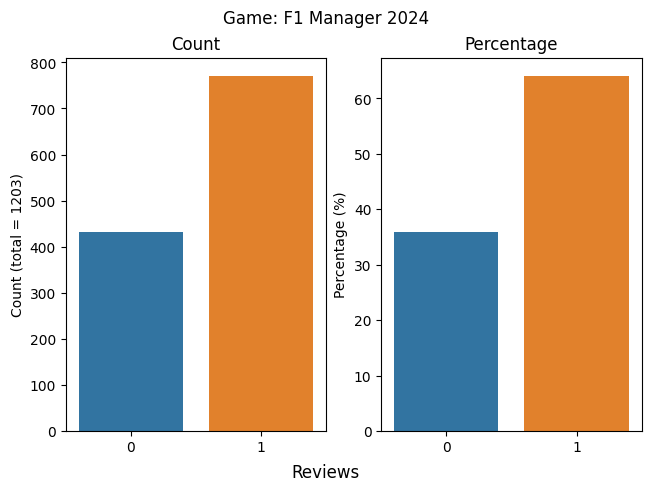

Top 20 most common words in reviews for 'F1 Manager 2024':

  game    not   team     on    bug   good driver   race    get     f1   like    car   just   make   play   more   some  still   time    fix 
  1838   1076    600    546    530    492    487    458    433    422    408    370    368    358    310    303    286    280    269    265 


This top 20 represents 20.91% or 10,099 out of the 48,289 total frequencies.

While 20 words represents 0.43% out of the total 4,675 unique words.

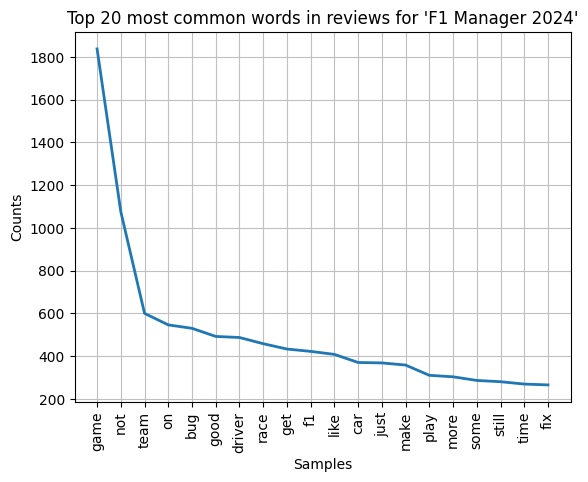

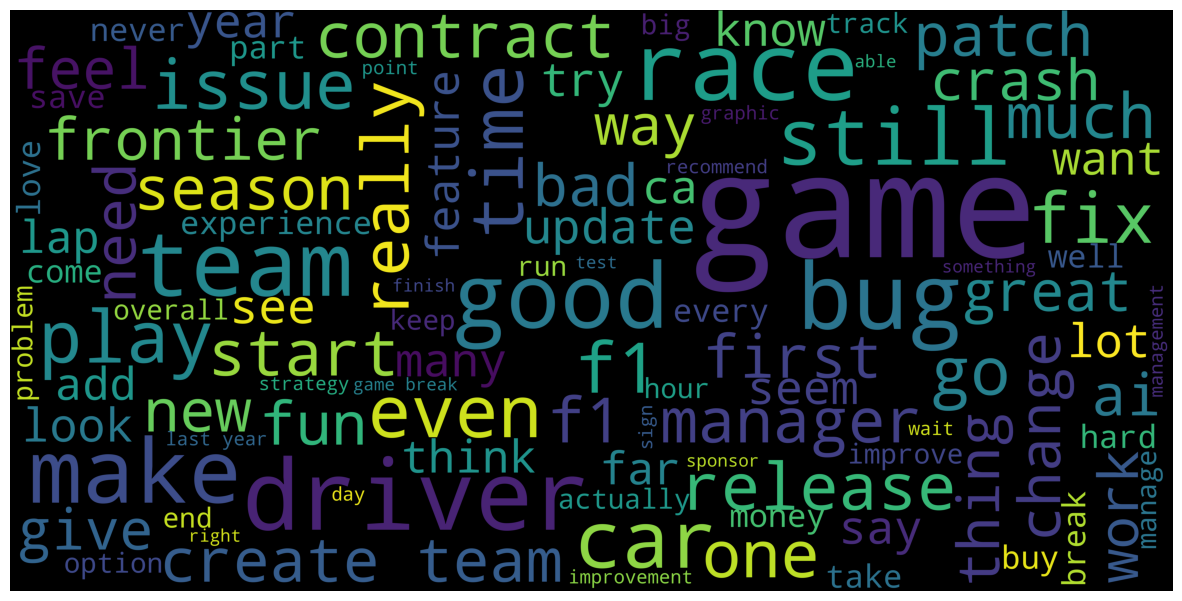

In [43]:
# Run the pre machine learning tasks
game: Game = pre_ml_task("F1 Manager 2024", "2591280")
# game: Game = pre_ml_task("Trials Fusion", "245490")

### ML

In [ ]:
def show_metrics_task(game: Game | None = None, models_names: list[str] | None = None):
    if game is None:
        game = cloudpkl_path_load("./saved_data/2591280/game.pkl")
    if models_names is None:
        models_names = ["kneighborsclf", "randomforestclf", "bernoullinb", "gaussiannb", "multinomialnb"]

    models_gs: dict[str, Any] = load_gridsearchcv_models(models_names)

    df_models: pd.DataFrame = gs_models_to_df(models_gs)
    df_metrics: pd.DataFrame = build_df_metrics(models_gs,df_models, game) # pyright: ignore[reportArgumentType]
    display(df_models)
    show_df_metrics(df_metrics, game) # pyright: ignore[reportArgumentType]
    return game, models_gs, df_metrics
game ,models_gs,df_metrics= show_metrics_task(game)

[11/12/24 17:29:26] INFO     Pickle file ./saved_data/2591280/game.pkl loaded                      ]8;id=700395;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py\1792245832.py]8;;\:]8;id=182558;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py#52\52]8;;\

                    INFO     Pickle file ./models/kneighborsclf_grid.pkl loaded                    ]8;id=157944;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py\1792245832.py]8;;\:]8;id=302223;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py#52\52]8;;\

                    INFO     Pickle file ./models/randomforestclf_grid.pkl loaded                  ]8;id=143732;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py\1792245832.py]8;;\:]8;id=806279;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py#52\52]8;;\

                    INFO     Pickle file ./models/bernoullinb_grid.pkl loaded                      ]8;id=15665;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py\1792245832.py]8;;\:]8;id=453308;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py#52\52]8;;\

                    INFO     Pickle file ./models/gaussiannb_grid.pkl loaded                       ]8;id=800477;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py\1792245832.py]8;;\:]8;id=871944;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py#52\52]8;;\

                    INFO     Pickle file ./models/multinomialnb_grid.pkl loaded                    ]8;id=216460;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py\1792245832.py]8;;\:]8;id=438076;file://C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_12808\1792245832.py#52\52]8;;\

TF-IDF                                            Metrics  \
                binary max_df min_df ngram_range norm validation_accuracy   
Models                                                                      
multinomialnb    False    0.4      5      (1, 2)   l2               0.863   
kneighborsclf    False    0.2      3      (1, 2)   l1               0.845   
bernoullinb      False    1.0      3      (1, 1)   l2               0.823   
randomforestclf   True    0.4      3      (1, 1)   l2               0.820   
gaussiannb       False    0.2      3      (2, 3)   l2               0.762   

                               
                test_accuracy  
Models                         
multinomialnb           0.840  
kneighborsclf           0.820  
bernoullinb             0.824  
randomforestclf         0.853  
gaussiannb              0.775

Accuracy base line: 0.641

Metrics,validation_accuracy,accuracy,precision_macro,recall_macro,f1_score_macro,roc_auc,matthews_corrcoef,log_loss,brier_score_loss
Models,,,,,,,,,
multinomialnb,0.863,0.840,0.855,0.795,0.812,0.795,0.647,0.387,0.120
kneighborsclf,0.845,0.820,0.805,0.804,0.804,0.804,0.609,0.446,0.146
bernoullinb,0.823,0.824,0.827,0.782,0.796,0.782,0.607,0.638,0.151
randomforestclf,0.820,0.853,0.854,0.821,0.833,0.821,0.675,0.370,0.113
gaussiannb,0.762,0.775,0.755,0.752,0.754,0.752,0.508,8.127,0.225


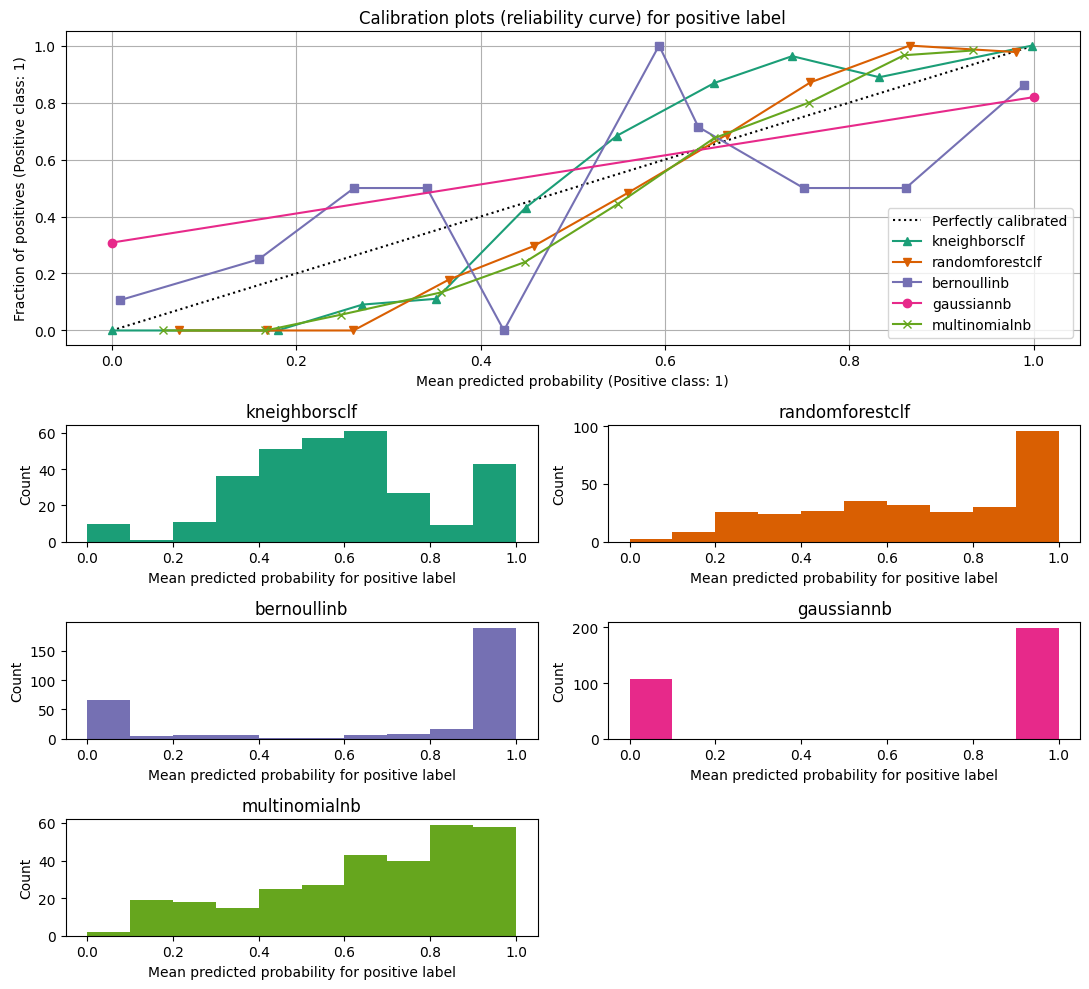

In [41]:
def show_calibration_curve_task(game: Game, models_gs: dict[str, Any]):
    X_train, X_test, y_train, y_test = split_data(game, random_state=game.random_state)

    fig = plt.figure(figsize=(11, 10))
    gs = GridSpec(5, 2)
    colors = plt.get_cmap("Dark2")

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])

    calibration_displays = {}
    markers = ["^", "v", "s", "o", "x"]

    for i, (name, gridsearch_model) in enumerate(models_gs.items()):
        y_prob = gridsearch_model.predict_proba(X_test)[:,1]
        CalibrationDisplay.from_predictions(
            y_test,
            y_prob,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
            marker=markers[i],
        )
        calibration_displays[name] = y_prob

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots (reliability curve) for positive label")

    grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4,0)]

    for i, (name, _) in enumerate(models_gs.items()):
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name],
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability for positive label", ylabel="Count")

    plt.tight_layout()
    plt.show()
show_calibration_curve_task(game, models_gs)

### Algo

In [ ]:
vis 